In [2]:
!pip install snowflake-connector-python pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 8.2 MB/s eta 0:00:00


In [8]:
from google.colab import userdata
import snowflake.connector
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Connect to Snowflake
user = userdata.get('user')
password = userdata.get('password')
account = userdata.get('account')
warehouse = userdata.get('warehouse')
database = userdata.get('database')
schema = userdata.get('schema')

# Establish the Snowflake connection
conn = snowflake.connector.connect(
    user=user,
    password=password,
    account=account,
    warehouse=warehouse,
    database=database,
    schema=schema
)

# SQL query to select data
query = """
SELECT DATE, LAT, LONG, CURRENT_SPEED, FREE_SPEED
FROM TRAFFIC_DATA
"""
df = pd.read_sql(query, conn)


<ipython-input-8-19088a7ac5b5>:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [9]:
# Calculate speed ratio and normalized speed
df['speed_ratio'] = df['CURRENT_SPEED'] / df['FREE_SPEED']
df['normalized_speed'] = df['FREE_SPEED'] / df['FREE_SPEED'].min()

In [10]:
# Define features and target variable
X = df[['LAT', 'LONG', 'FREE_SPEED', 'normalized_speed']]
y = df['CURRENT_SPEED']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [11]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [12]:
# Assuming y_pred is already computed as shown in your previous code snippets

# Add 'CURRENT_SPEED' to X_test for displaying
X_test['CURRENT_SPEED'] = y_test  # y_test contains the actual CURRENT_SPEED values

# Add predictions to the test DataFrame
X_test['predicted_speed'] = y_pred

# Display the test DataFrame with actual and predicted speeds
display(X_test)


,LAT,LONG,FREE_SPEED,normalized_speed,CURRENT_SPEED,predicted_speed
502503,37.342529,-121.900549,37.0,1.681818,37.0,30.253986
125337,37.351130,-121.915824,55.0,2.500000,55.0,46.721954
472443,37.356679,-121.905743,32.0,1.454545,23.0,27.797501
272435,37.358234,-121.907770,56.0,2.545455,56.0,48.318586
179939,37.366787,-121.921552,109.0,4.954545,109.0,94.375696
...,...,...,...,...,...,...
220134,37.375951,-121.882339,33.0,1.500000,33.0,30.659185
369732,37.361110,-121.876792,107.0,4.863636,107.0,91.410528
97097,37.340274,-121.913880,39.0,1.772727,39.0,31.849601
251584,37.353548,-121.894896,34.0,1.545455,34.0,28.969609


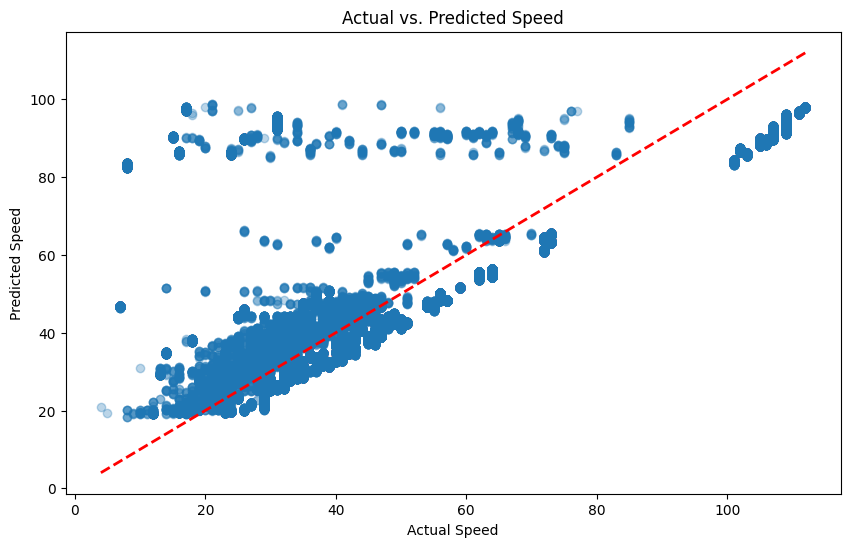

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs. Predicted Speed')
plt.show()


In [14]:
X_test['is_congested'] = X_test['predicted_speed'] < 0.8 * X_test['FREE_SPEED']

# Display the test DataFrame with actual and predicted speeds along with congestion flags
display(X_test)

,LAT,LONG,FREE_SPEED,normalized_speed,CURRENT_SPEED,predicted_speed,is_congested
502503,37.342529,-121.900549,37.0,1.681818,37.0,30.253986,False
125337,37.351130,-121.915824,55.0,2.500000,55.0,46.721954,False
472443,37.356679,-121.905743,32.0,1.454545,23.0,27.797501,False
272435,37.358234,-121.907770,56.0,2.545455,56.0,48.318586,False
179939,37.366787,-121.921552,109.0,4.954545,109.0,94.375696,False
...,...,...,...,...,...,...,...
220134,37.375951,-121.882339,33.0,1.500000,33.0,30.659185,False
369732,37.361110,-121.876792,107.0,4.863636,107.0,91.410528,False
97097,37.340274,-121.913880,39.0,1.772727,39.0,31.849601,False
251584,37.353548,-121.894896,34.0,1.545455,34.0,28.969609,False


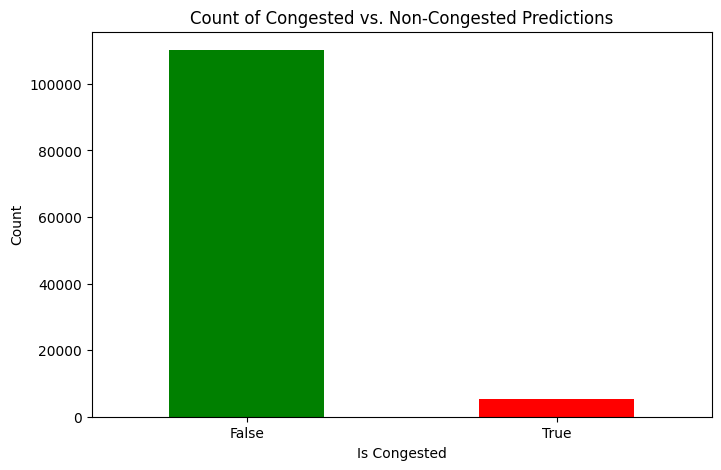

In [15]:
# Count the number of True and False values in the 'is_congested' column
congestion_counts = X_test['is_congested'].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 5))
congestion_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Count of Congested vs. Non-Congested Predictions')
plt.xlabel('Is Congested')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
